In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#run pipeline - creates and populates image directories
%run -i 'local_jpg_directory_pipeline.py'   

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:822: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


In [2]:
import pathlib
data_dir = pathlib.Path('Male_vs_Female')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

62

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 62 files belonging to 2 classes.
Using 50 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 62 files belonging to 2 classes.
Using 12 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['By Female', 'By Male']


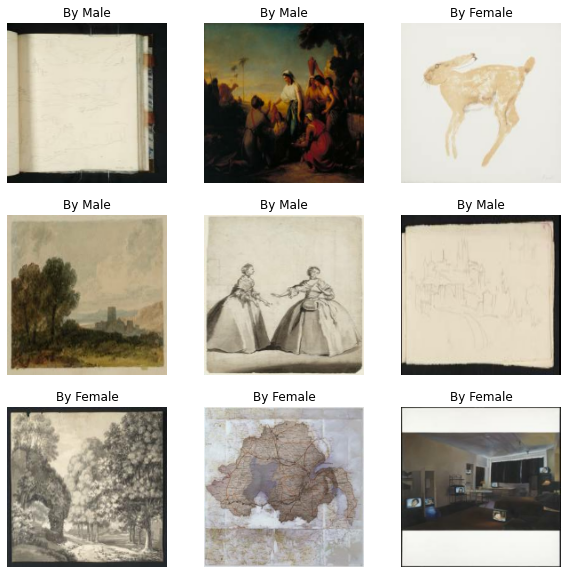

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008727282 0.95698655


In [13]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [25]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
2/2 [==============================] - 1s 426ms/step - loss: 0.4090 - accuracy: 0.7600 - val_loss: 0.8662 - val_accuracy: 0.6667
Epoch 2/30
2/2 [==============================] - 1s 421ms/step - loss: 0.4097 - accuracy: 0.7800 - val_loss: 0.9014 - val_accuracy: 0.5833
Epoch 3/30
2/2 [==============================] - 1s 403ms/step - loss: 0.3610 - accuracy: 0.8600 - val_loss: 0.9139 - val_accuracy: 0.5833
Epoch 4/30
2/2 [==============================] - 1s 269ms/step - loss: 0.3669 - accuracy: 0.8600 - val_loss: 0.9620 - val_accuracy: 0.5833
Epoch 5/30
2/2 [==============================] - 1s 416ms/step - loss: 0.3355 - accuracy: 0.8800 - val_loss: 1.0580 - val_accuracy: 0.5833
Epoch 6/30
2/2 [==============================] - 1s 412ms/step - loss: 0.3176 - accuracy: 0.8200 - val_loss: 1.1280 - val_accuracy: 0.6667
Epoch 7/30
2/2 [==============================] - 1s 418ms/step - loss: 0.3352 - accuracy: 0.8400 - val_loss: 1.1558 - val_accuracy: 0.5833
Epoch 8/30
2/2 [====

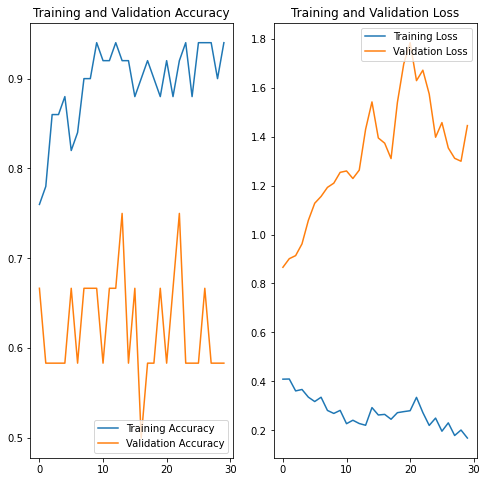

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

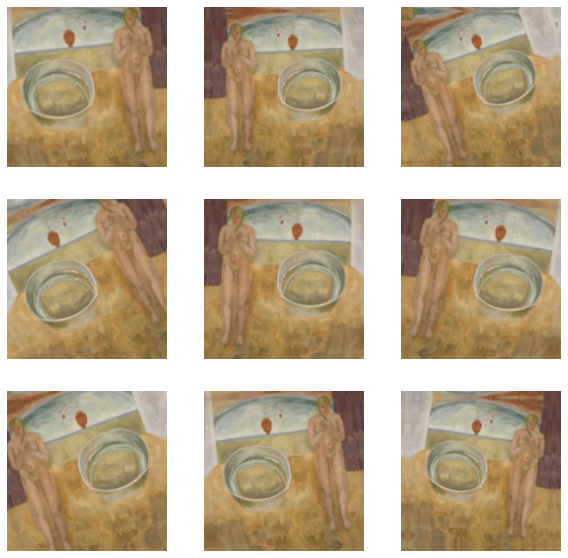

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [29]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [30]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
2/2 [==============================] - 1s 378ms/step - loss: 0.6882 - accuracy: 0.4450 - val_loss: 2.4202 - val_accuracy: 0.3333
Epoch 2/30
2/2 [==============================] - 1s 435ms/step - loss: 2.7323 - accuracy: 0.5133 - val_loss: 1.7958 - val_accuracy: 0.6667
Epoch 3/30
2/2 [==============================] - 1s 428ms/step - loss: 1.8059 - accuracy: 0.5400 - val_loss: 1.2342 - val_accuracy: 0.3333
Epoch 4/30
2/2 [==============================] - 1s 279ms/step - loss: 1.0883 - accuracy: 0.4762 - val_loss: 0.9505 - val_accuracy: 0.3333
Epoch 5/30
2/2 [==============================] - 1s 281ms/step - loss: 0.8061 - accuracy: 0.5400 - val_loss: 0.6263 - val_accuracy: 0.8333
Epoch 6/30
2/2 [==============================] - 1s 444ms/step - loss: 0.6401 - accuracy: 0.5770 - val_loss: 0.6274 - val_accuracy: 0.6667
Epoch 7/30
2/2 [==============================] - 1s 435ms/step - loss: 0.6203 - accuracy: 0.5585 - val_loss: 0.6214 - val_accuracy: 0.7500
Epoch 8/30
2/2 [====

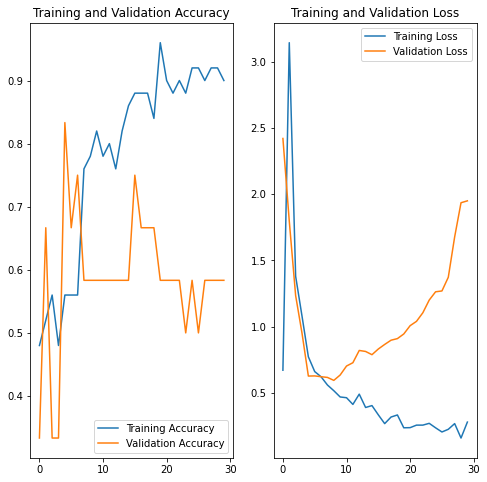

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()